The goals / steps of this project are the following:

Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Estimate a bounding box for vehicles detected.

## Imports

In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from skimage import data, exposure
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import random
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import datetime 
%matplotlib qt

C:\Users\leonl\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\leonl\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## load the data

In [2]:
cars = glob.glob('./downloads/vehicles/vehicles/*/*.png')
notcars = glob.glob('./downloads/non-vehicles/non-vehicles/*/*.png')
random.shuffle(cars)  
random.shuffle(notcars) 
print("there are : " + str(len(cars)) + " cars and : " + str(len(notcars)) + " not cars")

there are : 8792 cars and : 9650 not cars


## Apply SVM algorithm on the data. most code comes from udacity class

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def extract_single_features(jpg,img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    file_features = []
    # Read in each one by one
#     if jpg: 
#         img = img.astype(np.float32)/255
    image = img
    # apply color conversion if other than 'RGB'
    if jpg:
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)
    elif color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)    

# # apply grayscale
#     feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.extend(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.extend(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.extend(hog_features)
    #np.array(file_features).reshape(1, -1)
   
    #file_features = X_scaler.transform(np.array([file_features]).reshape(1, -1))
     #change the fit scalar
#     F_scaler = StandardScaler().fit(file_features)
#     file_features = F_scaler.transform(np.array([file_features]).reshape(1, -1))
    return file_features
    


def color_hist(img, nbins=32, bins_range=(0, 256)):    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, None] # Min and max in y to search in slide_window()
#y_start_stop = [380, None] # Min and max in y to search in slide_window()

t=time.time()
car_features = [extract_single_features(False,mpimg.imread(car), color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) for car in cars]
                                 
notcar_features = [extract_single_features(False,mpimg.imread(notcar), color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) for notcar in notcars]


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features))#.astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)


X_train= np.nan_to_num(X_train)

X_test = np.nan_to_num(X_test)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 

 


# Check the training time for the SVC
t=time.time()


svc = LinearSVC()
# svc = CalibratedClassifierCV(svm) 
# clf.fit(X_train, y_train)
# y_proba = clf.predict_proba(X_test)


svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 50
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

139.97 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4308
30.78 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9734
My SVC predicts:  [1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0.]
For these 50 labels:  [1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0.]
0.03368 Seconds to predict 50 labels with SVC


## now do a sliding window on an image 

In [4]:
import uuid
img = mpimg.imread('test_images/test1.jpg')

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img


def getCroppedImageFromLabel(img, labels):
    imgs = [] #marker
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        try:
            test_img = cv2.resize(img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]], (64, 64))
        except:
            continue
        imgs.append(test_img)
        bboxes.append(bbox)
#         #save images to use for training
#         outfile =  './extras/' + 'img' + str(uuid.uuid4()) + '.png'
#         #print("image location is: " + outfile)
#         cv2.imwrite(outfile, cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR))
#         # Return the image
    return imgs, bboxes





  

def validateBBoxes(img, labels): 
    imgs, bboxes = getCroppedImageFromLabel(img, labels)
    valid = []
    for i in range(0, len(imgs)):
        #test_img= cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB)
        test_img = imgs[i].astype(np.float32)/255
        imgFeature = extract_single_features(False,test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
#         decision = svc.decision_function(imgFeature)
#         print("Decision is: " + str(decision))
# #         if abs(decision) > 1.15:
#         X_extra = np.vstack((imgFeature))#.astype(np.float64)
        X_extra = np.nan_to_num(imgFeature)
        X_extra = X_scaler.transform([X_extra])
#         print(svc.predict(X_extra))
        if svc.predict(X_extra)[0] == 1:
#             print("Predicted true")
            valid.append(bboxes[i])
#             print(imgs[i])
#             imm = np.copy(img)
#             timg = cv2.resize(imm[bboxes[i][0][1]:bboxes[i][1][1], bboxes[i][0][0]:bboxes[i][1][0]], (64, 64))
#lll
#             outfile =  './extras/' + 'img' + str(uuid.uuid4()) + '.png'
# #             #print("image location is: " + outfile)
#             cv2.imwrite(outfile, cv2.cvtColor(imgs[i], cv2.COLOR_RGB2BGR))
    return valid

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace, spatial_size, hist_bins):
    #print(orient, pix_per_cell, cell_per_block,cspace, spatial_size, hist_bins)
    boxes = []
    draw_img = np.copy(img)
#     print(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
            if cspace == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
         
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
         
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
           
            
            
            #if hist_feat & spatial_feature:
            fp = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #fp = np.hstack((spatial_features, hog_features)).reshape(1, -1)
            #else: 
            #f1 = hist_features
            #f2 = hog_features
            #f3 = spatial_features
            #fp = np.hstack((f3,f1,f2)).reshape(1, -1)
            #fp = np.hstack((hog_features)).reshape(1, -1)
            
         
            
            fp = np.nan_to_num(fp)
            test_features = X_scaler.transform(fp)    
#             print(test_features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
#             print("Prediction is: " + str(test_prediction))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                boxes.append(box)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, boxes
    
def multiBoxes(img):
        
    boxes = []

#     scales = [1,1.4, 1.75, 2.5, 3, 3.5]
    #scales = [1, 1.5, 2, 2.5 , 3.5]
    
#     scales = [1, 1.5, 2, 2.5 , 3.5]
#     scales = [1, 1.2,1.4,1.5, 1.75, 2.5, 3, 3.5]
    
#     scales = [1.5]
    scales = [1,1.5, 1.8, 2, 2.2, 2.5, 2.8, 3, 3.2, 3.5]
    
    for i in range( 0 , len(scales)):
        ystart = 390
        ystop = 700
        scale = scales[i]

        out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space, spatial_size, hist_bins)
        boxes.extend(box_list)
   
    return boxes
    

#out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space, spatial_size, hist_bins)

#plt.imshow(out_img)
box_list = multiBoxes(img)
print("boxes")

boxes


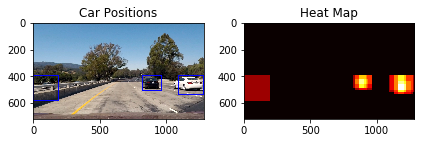

In [5]:
# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
valid = validateBBoxes(img, labels)
draw_img = np.copy(img)
for v in valid: 
    cv2.rectangle(draw_img,v[0],v[1],(0,0,255),6) 

    
# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


## detect in the rest of the images

In [6]:
img = mpimg.imread('test_images/test2.jpg')
   
#out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space, spatial_size, hist_bins)

#plt.imshow(out_img)

box_list = multiBoxes(img)
print("boxes")

boxes


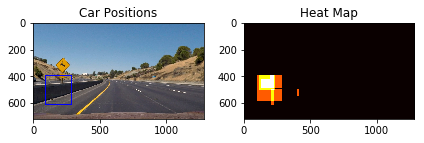

In [7]:
# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)


# Find final boxes from heatmap using label function
labels = label(heatmap)
valid = validateBBoxes(img, labels)
draw_img = np.copy(img)
for v in valid: 
    cv2.rectangle(draw_img,v[0],v[1],(0,0,255),6) 
    

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(img), labels)


fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [8]:
img = mpimg.imread('test_images/test3.jpg')
   
#out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space, spatial_size, hist_bins)

#plt.imshow(out_img)

box_list = multiBoxes(img)
print("boxes")

boxes


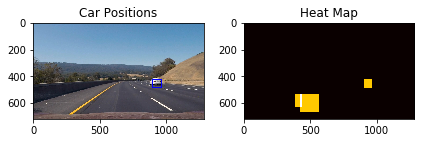

In [9]:
# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)


# Find final boxes from heatmap using label function
labels = label(heatmap)
valid = validateBBoxes(img, labels)
draw_img = np.copy(img)
for v in valid: 
    cv2.rectangle(draw_img,v[0],v[1],(0,0,255),6) 

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [10]:
img = mpimg.imread('test_images/test4.jpg')
   
#out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space, spatial_size, hist_bins)

#plt.imshow(out_img)

box_list = multiBoxes(img)
print("boxes")

boxes


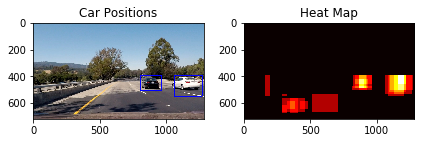

In [11]:
# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)


# Find final boxes from heatmap using label function
labels = label(heatmap)
valid = validateBBoxes(img, labels)
draw_img = np.copy(img)
for v in valid: 
    cv2.rectangle(draw_img,v[0],v[1],(0,0,255),6) 

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [12]:
img = mpimg.imread('test_images/test5.jpg')
   
#out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space, spatial_size, hist_bins)

#plt.imshow(out_img)

box_list = multiBoxes(img)
print("boxes")

boxes


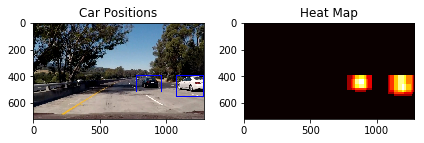

In [13]:
# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)


# Find final boxes from heatmap using label function
labels = label(heatmap)
valid = validateBBoxes(img, labels)
draw_img = np.copy(img)
for v in valid: 
    cv2.rectangle(draw_img,v[0],v[1],(0,0,255),6) 


# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [24]:
img = mpimg.imread('test_images/test6.jpg')
   
#out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space, spatial_size, hist_bins)

#plt.imshow(out_img)

box_list = multiBoxes(img)
print("boxes")

boxes


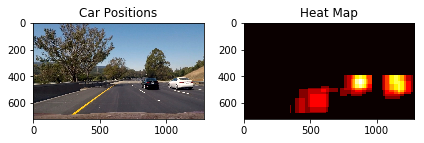

In [26]:
# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)


# Find final boxes from heatmap using label function
labels = label(heatmap)
valid = validateBBoxes(img, labels)
draw_img = np.copy(img)
for v in valid: 
    cv2.rectangle(draw_img,v[0],v[1],(0,0,255),6) 


# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Processing Pipeline

In [27]:

frameCounter = [0]

class FrameAndBox:
    def __init__(self, frame, box):
        self.frame = frame
        self.box = box
        


#this will hold cache of boxes accorss frames
pipeline_cache = []
new_cache = []


# # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#         heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

def find_overlap(bb1, bb2):
    x_left = max(bb1[0][1], bb2[0][1])
    y_top = max(bb1[1][1], bb2[1][1])
    x_right = min(bb1[0][0], bb2[0][0])
    y_bottom = min(bb1[1][0], bb2[1][0])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[0][0] - bb1[0][1]) * (bb1[1][0] - bb1[1][1])
    bb2_area = (bb2[0][0] - bb2[0][1]) * (bb2[1][0] - bb2[1][1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

def valid_overlap_cache(valid, cache, new_cache):
    for pc in pipeline_cache:
        if (valid.frame - pc.frame <= 5) and  find_overlap(valid.box, pc.box) > 0.9:
            cache.append(valid)
            return True
    for nc in new_cache:
        if (valid.frame - nc.frame <= 5) and  find_overlap(valid.box, nc.box) > 0.9:
            cache.append(valid)
            cache.append(nc)
            return True
    new_cache.append(valid)
    return False

def run_pipeline(img):
    #
    #now do a progressive scaling of the image as things gets nearer
  
    
    #out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space, spatial_size, hist_bins)
    box_list = multiBoxes(img)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)


    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    valid = validateBBoxes(img, labels)
#     _, valid = getCroppedImageFromLabel(img, labels)
    
    #now validate boxes accorss frames
    valid_to_draw = []
    frameCounter[0] = frameCounter[0] + 1
#     frameCounter = frameCounter + 1
    
    
    for v in valid:
        ov = FrameAndBox(frameCounter[0], v)
        if valid_overlap_cache(ov, pipeline_cache, new_cache):
            valid_to_draw.append(ov.box)
            
    
    draw_img = np.copy(img)
    for v in valid_to_draw: 
        cv2.rectangle(draw_img,v[0],v[1],(0,0,255),6)
        
    

#     # Find final boxes from heatmap using label function
#     labels = label(heatmap)
#     draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [28]:
print(frameCounter)

[0]


## Process video

In [30]:

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(run_pipeline)#.subclip(25,30) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [28:08<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 28min 9s
